```
# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)
```

(reference-grids)=
# Using the Atlas reference grids in `R`

22/07/2021

**M. Iturbide** ([Santander Meteorology Group](http://meteo.unican.es), Instituto de Física de Cantabria, CSIC-UC, Santander, Spain)

This is a simple example which illustrates how the Atlas reference grids can be used in `R` for both interpolation and land/sea separation of the simulations provided by a global climate model.

### Load libraries

The following climate4R (C4R hereafter) libraries are needed to run this notebook:

 * `loadeR` {cite:authorpar}`PackageVisualizeCommunicate` to load data
 * `visualizeR` to display the results
 * `convertR` to change units

In [1]:
library(loadeR)
library(visualizeR)
library(convertR)

Loading required package: rJava

Loading required package: loadeR.java

Java version 11x amd64 by Azul Systems, Inc. detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.4 (2022-06-15) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.7.1 (2021-07-05) is loaded

Please use 'citation("loadeR")' to cite this package.



ERROR: Error in library(visualizeR): there is no package called ‘visualizeR’


### Load the reference land/sea mask
The global reference 1º land/sea mask used for the generation of part of the Atlas products can be loaded directly from this repository with the `loadGridData` function:


In [ ]:
# global reference 1º land/sea mask
mask <- loadGridData("../reference-grids/land_sea_mask_1degree.nc4", var = "sftlf")

This mask is a C4R grid object which contains the land fraction (a value in between 0 and 1) in each gridbox.

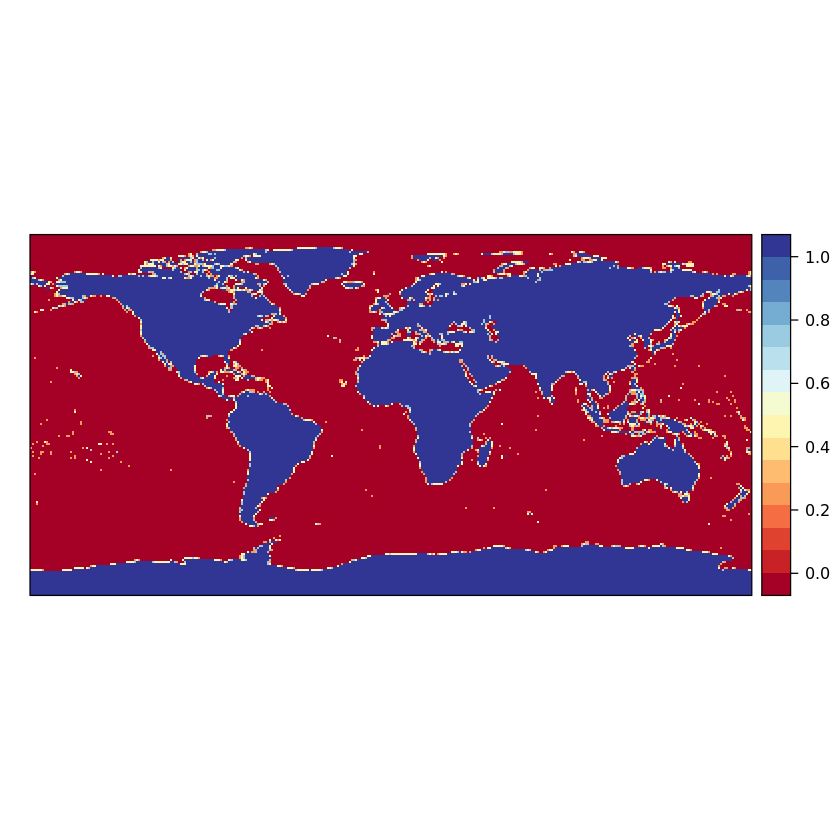

In [3]:
# plotting mask
spatialPlot(mask)

### Load model data

For this example we will use the global mean temperature from the CanESM5 model, which is provided at a monthly time resolution in a netCDF file in the `auxiliary-material` folder. In particular, we focus on the 2000-2010 period, which can be specified with the `years` argument in the `loadGridData` function:

In [ ]:
# loading global mean temperature
tas <- loadGridData("auxiliary-material/CMIP6Amon_tas_CanESM5_r1i1p1f1_historical_gn_185001-201412.nc", 
                    var = "tas", years = 2000:2010) 

Let's plot the climatology for the analyzed period:

[2021-07-22 10:57:18] - Computing climatology...

[2021-07-22 10:57:18] - Done.



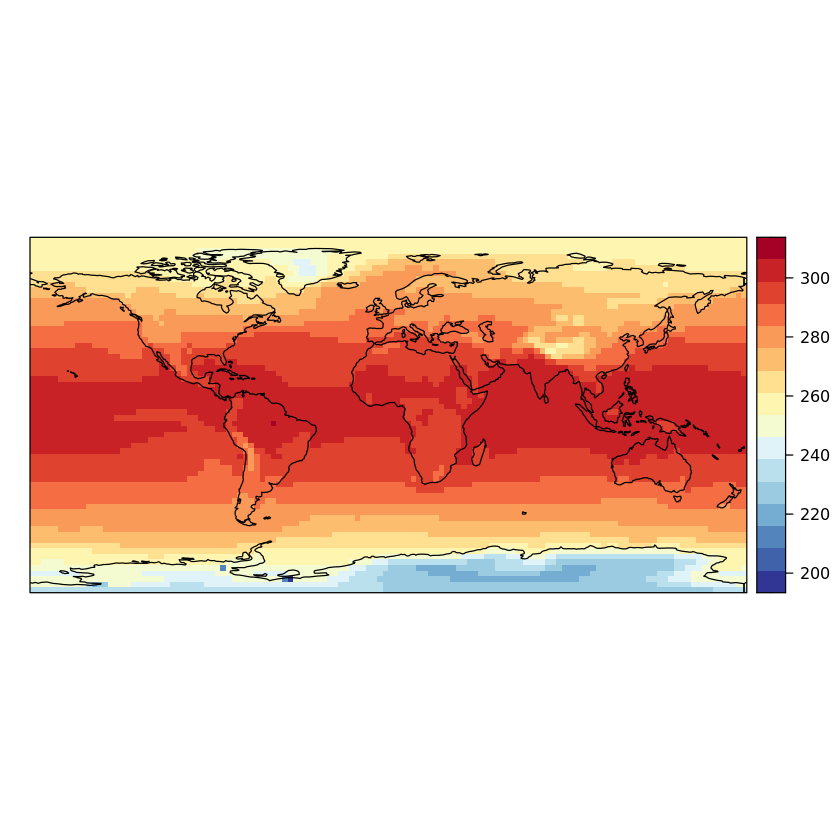

In [5]:
# plotting climatology
spatialPlot(climatology(tas), backdrop.theme = "coastline", rev.colors = TRUE)

### Interpolation

The global mean temperature we have just loaded comes in the original grid of the CanESM5 model, which has a spatial resolution of about 2.8º:

In [15]:
attributes(getGrid(tas))$resX
attributes(getGrid(tas))$resY

[1] 2.8125

[1] 2.789327

In order to apply the reference 1º land/sea mask to these data and retain only land temperatures, we need first to interpolate the CanESM5 model to the grid of the mask, which can be done with the `interpGrid` function. We will use in this example bilinear interpolation; however, other interpolation methods are also available in `interpGrid`.

In [ ]:
# Note: This cell may take a while to run 
tas.i <- interpGrid(tas, getGrid(mask), method = "bilinear")

In [16]:
attributes(getGrid(tas.i))$resX
attributes(getGrid(tas.i))$resY

[1] 1

[1] 1

### Apply the mask to the data

The `binaryGrid` function assigns two user-provided values (here NA and 1) to a given C4R grid object according to a threshold and condition. We use it here to obtain a new binary land/sea mask with 1 over land and NA over sea. Note that a threshold of 0.999 (99.9%) land fraction is used to define land/sea grid points.

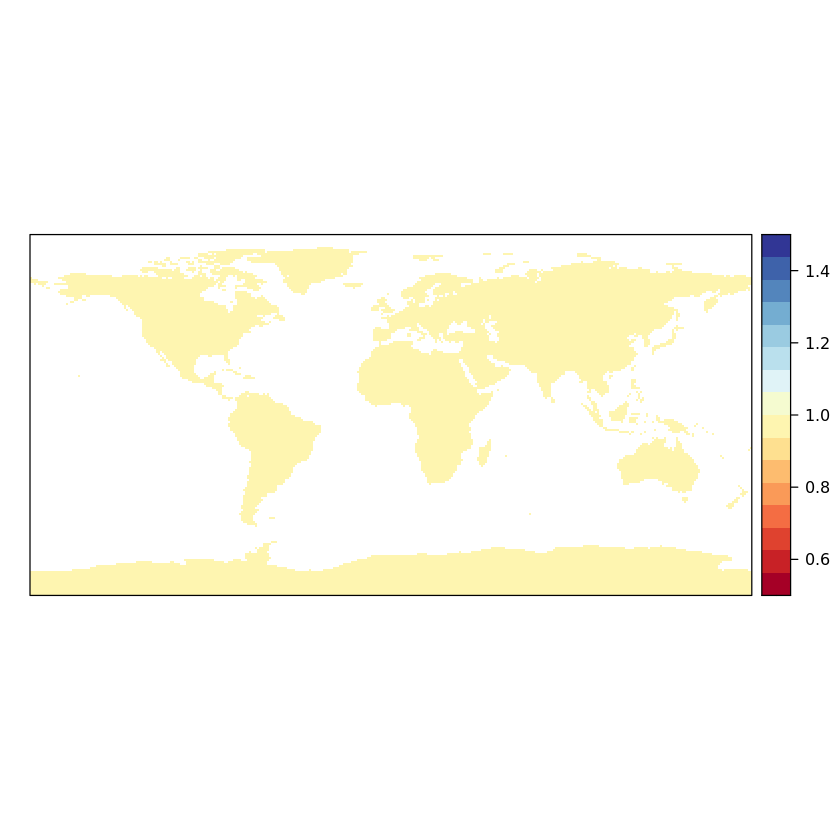

In [8]:
# binary 1º land/sea mask
land <- binaryGrid(mask, condition = "GT", threshold = 0.999, values = c(NA, 1))
spatialPlot(land)

In order to apply this binary mask to our temperature data, we need that both C4R grid objects have the same dimensions. Therefore, we resize the binary mask to match the time dimension of `tas.i`:

In [ ]:
masktimes <- rep(list(land), getShape(tas.i, "time"))
mask2apply <- bindGrid(masktimes, dimension = "time")

At this point, we can already use the `gridArithmetics` function to multiply the binary land/sea mask and the temperature data, making NA over sea in the latter.

[2021-07-22 10:57:55] - Computing climatology...

[2021-07-22 10:57:56] - Done.



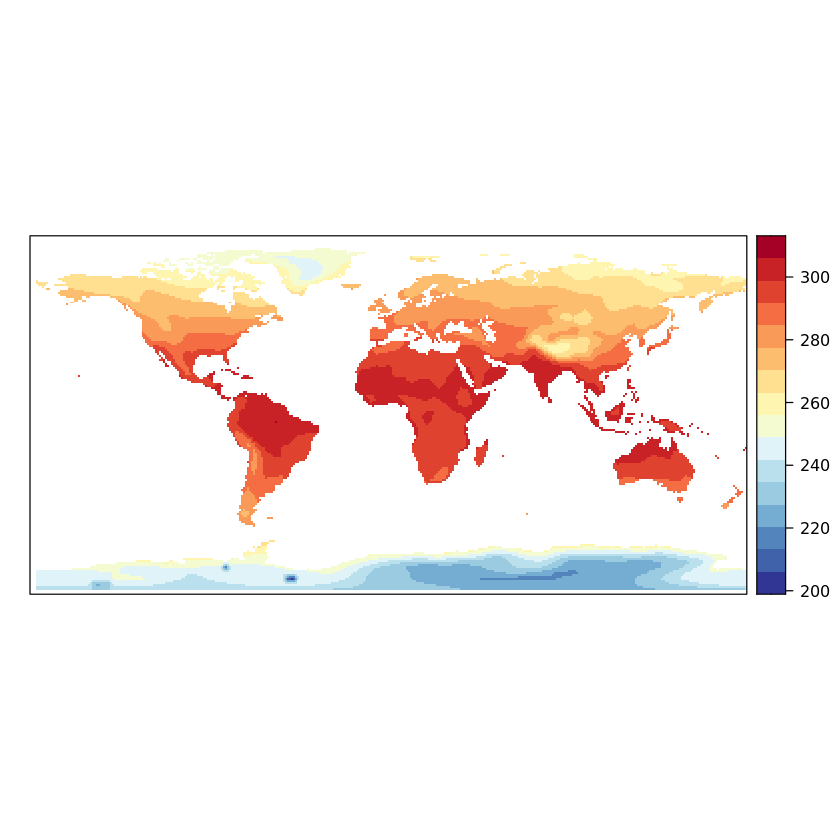

In [10]:
tas.i.land <- gridArithmetics(tas.i, mask2apply, operator = "*")

# final land-only temperature data
spatialPlot(climatology(tas.i.land), rev.colors = TRUE)  

### Masked vs. non masked time-series

Next we compare the monthly time-series of mean temperature, spatially averaged over the entire globe (non masked: `tas.i`) and only over land regions (masked: `tas.i.land`):

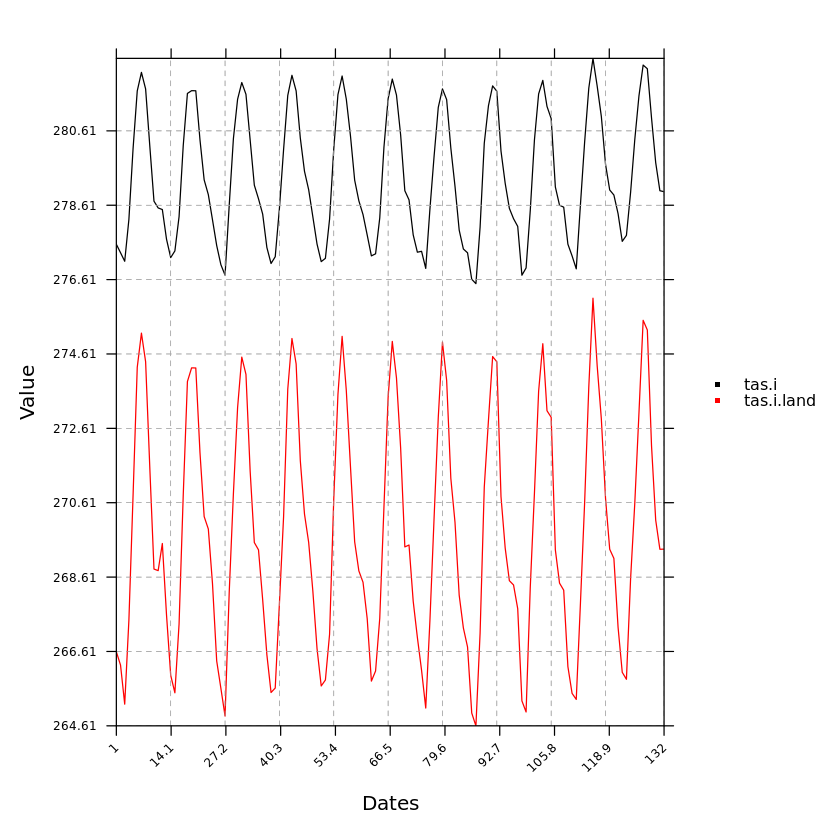

In [11]:
# monthly time-series (in K)
temporalPlot(tas.i, tas.i.land, x.axis = "index")

Note that temperature is in K units. The `udConvertGrid` function from the `convertR` package allows for easily passing from K to Celsius degrees:

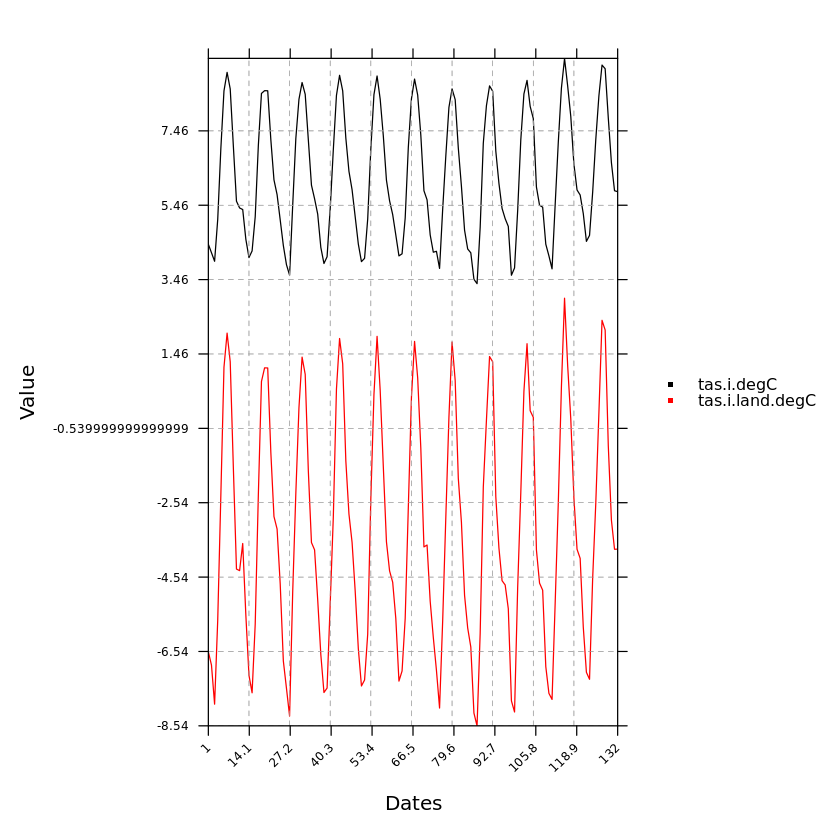

In [12]:
# monthly time-series (in Celsius degrees)
tas.i.degC <- udConvertGrid(tas.i, new.units = "degC")
tas.i.land.degC <- udConvertGrid(tas.i.land, new.units = "degC")
temporalPlot(tas.i.degC, tas.i.land.degC, x.axis = "index")

### Session info

In [13]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] convertR_0.2.0      udunits2_0.13       visualizeR_1.6.1   
[4] transformeR_2.1.2   loadeR_1.7.1        climate4R.UDG_0.2.3
[7] loadeR.java_1.1.1   rJava_1.0-4        

loaded via a namespace (and not attached):
 [1] viridis_0.6.1           maps_3.3.0              jsonlite_1

### References

```{bibliography}
:filter: docname in docnames
```

<script src="https://utteranc.es/client.js"
        repo="PhantomAurelia/Atlas"
        issue-term="pathname"
        theme="preferred-color-scheme"
        crossorigin="anonymous"
        async>
</script>